jupyter nbconvert --to slides --reveal-prefix "http://cdn.jsdelivr.net/reveal.js/2.6.2"

In [2]:
import pods
from matplotlib import pyplot as plt
%matplotlib inline

# MLAI Week 3: Regression

### Neil D. Lawrence

### 13th October 2015

### Review
- Last time: Looked at objective functions for movie recommendation.
- Minimized sum of squares objective by steepest descent and stochastic gradients.
- This time: explore least squares for regression.

### Regression Examples

-   Predict a real value, $y_i$ given some inputs
    $x_i$.

-   Predict quality of meat given spectral measurements (Tecator data).

-   Radiocarbon dating, the C14 calibration curve: predict age given
    quantity of C14 isotope.

-   Predict quality of different Go or Backgammon moves given expert
    rated training data.


### Olympic 100m Data

-  Gold medal times for Olympic 100 m runners since 1896.

![image](./diagrams/100m_final_start.jpg)
Image from Wikimedia Commons <http://bit.ly/191adDC>

### Olympic 100m Data


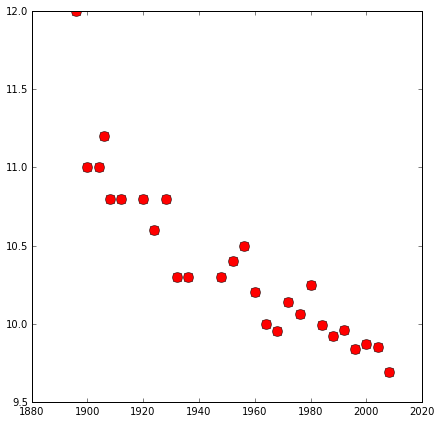

In [3]:
data = pods.datasets.olympic_100m_men()
f, ax = plt.subplots(figsize=(7,7))
ax.plot(data['X'], data['Y'], 'ro', markersize=10)

### Olympic Marathon Data

-   Gold medal times for Olympic Marathon since 1896.

-   Marathons before 1924 didn’t have a standardised distance.

-   Present results using pace per km.

-   In 1904 Marathon was badly organised leading to very slow times.

![image](./diagrams/Stephen_Kiprotich.jpg)
Image from Wikimedia Commons <http://bit.ly/16kMKHQ>


### Olympic Marathon Data


In [1]:
data = pods.datasets.olympic_marathon_men()
f, ax = plt.subplots(figsize=(7,7))
ax.plot(data['X'], data['Y'], 'ro',markersize=10)

NameError: name 'pods' is not defined

### What is Machine Learning?

$$ \text{data} + \text{model} = \text{prediction}$$

-   $\text{data}$ : observations, could be actively or passively
    acquired (meta-data).

-   $\text{model}$ : assumptions, based on previous experience (other data!
    transfer learning etc), or beliefs about the regularities of
    the universe. Inductive bias.

-   $\text{prediction}$ : an action to be taken or a categorization or a
    quality score.


### Regression: Linear Releationship

$$y_i = m x_i + c$$

-   $y_i$ : winning time/pace.

-   $x_i$ : year of Olympics.

-   $m$ : rate of improvement over time.

-   $c$ : winning time at year 0.

# Overdetermined System

![](diagrams/straight_line7.svg)

# $y = mx + c$

point 1: $x = 1$, $y=3$ $$3 = m + c$$ 
point 2: $x = 3$, $y=1$ $$1 = 3m + c$$ 
point 3: $x = 2$, $y=2.5$ $$2.5 = 2m + c$$

<img src="diagrams/Pierre-Simon_Laplace.png" align=center width=50%>

# $y = mx + c + \epsilon$

point 1: $x = 1$, $y=3$ 
$$3 = m + c + \epsilon_1$$ 

point 2: $x = 3$, $y=1$ 
$$1 = 3m + c + \epsilon_2$$ 

point 3: $x = 2$, $y=2.5$ 
$$2.5 = 2m + c + \epsilon_3$$

### The Gaussian Density
- Perhaps the most common probability density.
\begin{align*}
p(y| \mu, \sigma^2) & = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y - \mu)^2}{2\sigma^2}\right)\\
& \buildrel\triangle\over = \mathcal{N}(y|\mu, \sigma^2)
\end{align*}
- The Gaussian density.


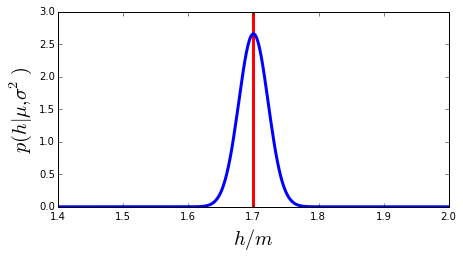

In [5]:
import numpy as np
h = np.linspace(0, 2.5, 1000)
sigma2 = 0.0225
mu = 1.7
p = 1./np.sqrt(2*np.pi*sigma2)*np.exp(-(h-mu)**2/(2*sigma2**2))
f2, ax2 = plt.subplots(figsize=(7, 3.5))
ax2.plot(h, p, 'b-', linewidth=3)
ylim = (0, 3)
ax2.vlines(mu, ylim[0], ylim[1], colors='r', linewidth=3)
ax2.set_ylim(ylim)
ax2.set_xlim(1.4, 2.0)
ax2.set_xlabel('$h/m$', fontsize=20)
ax2.set_ylabel('$p(h|\mu, \sigma^2)$', fontsize = 20)
f2.savefig('./diagrams/gaussian_of_height.svg')

### Gaussian Density
![](./diagrams/gaussian_of_height.svg)
The Gaussian PDF with $\mu=1.7$ and variance $\sigma^2=
  0.0225$. Mean shown as red line. It could represent the heights of a population of
  students.

### Gaussian Density
$$
\mathcal{N}(y|\mu, \sigma^2) =  \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y-\mu)^2}{2\sigma^2}\right)
$$
$\sigma^2$ is the variance of the density and $\mu$ is the mean.



### Two Important Gaussian Properties

**Sum of Gaussian**

-   Sum of Gaussian variables is also Gaussian.
    $$y_i \sim \mathcal{N}(\mu, \sigma^2)$$ 
    And the sum is distributed as
    $$\sum_{i=1}^{n} y_i \sim \mathcal{N}\left(\sum_{i=1}^n \mu_i,\sum_{i=1}^n \sigma_i^2\right)$$
    (*Aside*: As sum increases, sum of non-Gaussian, finite variance variables is
    also Gaussian [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).)

### Two Important Gaussian Properties

**Scaling a Gaussian**

-   Scaling a Gaussian leads to a Gaussian.
    $$y \sim \mathcal{N}(\mu, \sigma^2)$$
    And the scaled density is distributed as
    $$w y \sim \mathcal{N}(w\mu,w^2 \sigma^2)$$

### Laplace's Idea

### A Probabilistic Process

-   Set the mean of Gaussian to be a function.
    $$p\left(y_i|x_i\right)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp \left(-\frac{\left(y_i-f\left(x_i\right)\right)^{2}}{2\sigma^2}\right).$$

-   This gives us a ‘noisy function’.

-   This is known as a stochastic process.

### Height as a Function of Weight

-   In the standard Gaussian, parametized by mean and variance.

-   Make the mean a linear function of an *input*.

-   This leads to a regression model. 
    \begin{align*}
       y_i=&f\left(x_i\right)+\epsilon_i,\\
         \epsilon_i \sim &\mathcal{N}(0, \sigma^2).
     \end{align*}
        
-   Assume $y_i$ is height and $x_i$ is weight.

### Data Point Likelihood

-   Likelihood of an individual data point
    $$p\left(y_i|x_i,m,c\right)=\frac{1}{\sqrt{2\pi \sigma^2}}\exp \left(-\frac{\left(y_i-mx_i-c\right)^{2}}{2\sigma^2}\right).$$

-   Parameters are gradient, $m$, offset, $c$ of the function and noise
    variance $\sigma^2$.

### Data Set Likelihood

-   If the noise, $\epsilon_i$ is sampled independently for each
    data point.

-   Each data point is independent (given $m$ and $c$).

-   For independent variables:
    $$p(\mathbf{y}) = \prod_{i=1}^n p(y_i)$$
    $$p(\mathbf{y}|\mathbf{x}, m, c) = \prod_{i=1}^n p(y_i|x_i, m, c)$$
    

### For Gaussian 

- i.i.d. assumption
    
    $$p(\mathbf{y}|\mathbf{x}, m, c) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi \sigma^2}}\exp \left(-\frac{\left(y_i-mx_i-c\right)^{2}}{2\sigma^2}\right).$$
    $$p(\mathbf{y}|\mathbf{x}, m, c) = \frac{1}{\left(2\pi \sigma^2\right)^{\frac{n}{2}}}\exp \left(-\frac{\sum_{i=1}^n\left(y_i-mx_i-c\right)^{2}}{2\sigma^2}\right).$$

### Log Likelihood Function

-   Normally work with the log likelihood:
    $$L(m,c,\sigma^{2})=-\frac{n}{2}\log 2\pi -\frac{n}{2}\log \sigma^2 -\sum _{i=1}^{n}\frac{\left(y_i-mx_i-c\right)^{2}}{2\sigma^2}.$$

### Consistency of Maximum Likelihood


-   If data was really generated according to probability we specified.

-   Correct parameters will be recovered in limit as
    $n \rightarrow \infty$.

-   This can be proven through sample based approximations (law of
    large numbers) of “KL divergences”.

-   Mainstay of classical statistics.

### Probabilistic Interpretation of the Error Function

-   Probabilistic Interpretation for Error Function is Negative
    Log Likelihood.

-   *Minimizing* error function is equivalent to *maximizing*
    log likelihood.

-   Maximizing *log likelihood* is equivalent to maximizing the
    *likelihood* because $\log$ is monotonic.

-   Probabilistic interpretation: Minimizing error function is
    equivalent to maximum likelihood with respect to parameters.

### Error Function

-   Negative log likelihood is the error function leading to an error
    function
    $$E(m,c,\sigma^{2})=\frac{n}{2}\log \sigma^2 +\frac{1}{2\sigma^2}\sum _{i=1}^{n}\left(y_i-mx_i-c\right)^{2}.$$

-   Learning proceeds by minimizing this error function for the data
    set provided.

### Connection: Sum of Squares Error

-   Ignoring terms which don’t depend on $m$ and $c$ gives
    $$E(m, c) \propto \sum_{i=1}^n (y_i - f(x_i))^2$$
    where $f(x_i) = mx_i + c$.

-   This is known as the *sum of squares* error function.

-   Commonly used and is closely associated with the
    Gaussian likelihood.

## Reminder

- Two functions involved:
  - Prediction function: $f(x_i)$
  - Error, or Objective function: $E(m, c)$
- Error function depends on parameters through prediction function.

### Mathematical Interpretation

-   What is the mathematical interpretation?

    -   There is a cost function.

    -   It expresses mismatch between your prediction and reality.
        $$E(m, c)=\sum_{i=1}^n \left(y_i - mx_i -c\right)^2$$

    -   This is known as the sum of squares error.

### Learning is Optimization

-   Learning is minimization of the cost function.

-   At the minima the gradient is zero.

-   Coordinate ascent, find gradient in each coordinate and set to zero.
    $$\frac{\text{d}E(m)}{\text{d}m} =
          -2\sum_{i=1}^n x_i
          \left(y_i- m x_i - c \right)$$
    $$0 =
          -2\sum_{i=1}^n x_i
          \left(y_i-
            m x_i - c \right)$$            


### Learning is Optimization

- Fixed point equations
    $$0 =
          -2\sum_{i=1}^n x_iy_i
          +2\sum_{i=1}^n
            m x_i^2 +2\sum_{i=1}^n cx_i$$
    $$m  =    \frac{\sum_{i=1}^n \left(y_i
          -c\right)x_i}{\sum_{i=1}^nx_i^2}$$

### Learning is Optimization

-   Learning is minimization of the cost function.

-   At the minima the gradient is zero.

-   Coordinate ascent, find gradient in each coordinate and set to zero.
     $$\frac{\text{d}E(c)}{\text{d}c} =
          -2\sum_{i=1}^n 
          \left(y_i- m x_i - c \right)$$
    $$0 =
          -2\sum_{i=1}^n\left(y_i-
            m x_i - c \right)$$
    

## Learning is Optimization

- Fixed point equations
    $$0 = -2\sum_{i=1}^n y_i +2\sum_{i=1}^n m x_i +2n c$$
    $$c  =    \frac{\sum_{i=1}^n \left(y_i
          -mx_i\right)}{n}$$

### Fixed Point Updates

Worked example. $$\begin{aligned}
    c^{*}=&\frac{\sum _{i=1}^{n}\left(y_i-m^{*}x_i\right)}{n},\\
    m^{*}=&\frac{\sum _{i=1}^{n}x_i\left(y_i-c^{*}\right)}{\sum _{i=1}^{n}x_i^{2}},\\
    \left.\sigma^2\right.^{*}=&\frac{\sum _{i=1}^{n}\left(y_i-m^{*}x_i-c^{*}\right)^{2}}{n}
  \end{aligned}$$

### Important Concepts Not Covered

-   Other optimization methods:

    -   Second order methods, conjugate gradient, quasi-Newton
        and Newton.

    -   Effective heuristics such as momentum.

-   Local vs global solutions.

### Reading

- Section 1.1-1.2 of @Rogers:book11 for fitting linear models. 
- Section 1.2.5 of @Bishop:book06 up to equation 1.65.


### Multi-dimensional Inputs

-   Multivariate functions involve more than one input.

-   Height might be a function of weight and gender.

-   There could be other contributory factors.

-   Place these factors in a feature vector $\mathbf{x}_i$.

-   Linear function is now defined as
    $$f(\mathbf{x}_i) = \sum_{j=1}^p w_j x_{i, j} + c$$

### Vector Notation

-   Write in vector notation,
    $$f(\mathbf{x}_i) = \mathbf{w}^\top \mathbf{x}_i + c$$

-   Can absorb $c$ into $\mathbf{w}$ by assuming extra input $x_0$
    which is always 1.
    $$f(\mathbf{x}_i) = \mathbf{w}^\top \mathbf{x}_i$$

### Log Likelihood for Multivariate Regression

-   The likelihood of a single data point is
    $$p\left(y_i|x_i\right)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp
        \left(-\frac{\left(y_i-\mathbf{w}^{\top}\mathbf{x}_i\right)^{2}}{2\sigma^2}\right).$$

-   Leading to a log likelihood for the data set of
    $$L(\mathbf{w},\sigma^2)= -\frac{n}{2}\log \sigma^2
          -\frac{n}{2}\log 2\pi -\frac{\sum
            _{i=1}^{n}\left(y_i-\mathbf{w}^{\top}\mathbf{x}_i\right)^{2}}{2\sigma^2}.$$

-   And a corresponding error function of
    $$E(\mathbf{w},\sigma^2)= \frac{n}{2}\log
          \sigma^2 + \frac{\sum
            _{i=1}^{n}\left(y_i-\mathbf{w}^{\top}\mathbf{x}_i\right)^{2}}{2\sigma^2}.$$

### Expand the Brackets

\begin{align*}
  E(\mathbf{w},\sigma^2)  = & \frac{n}{2}\log \sigma^2 + \frac{1}{2\sigma^2}\sum _{i=1}^{n}y_i^{2}-\frac{1}{\sigma^2}\sum _{i=1}^{n}y_i\mathbf{w}^{\top}\mathbf{x}_i\\&+\frac{1}{2\sigma^2}\sum _{i=1}^{n}\mathbf{w}^{\top}\mathbf{x}_i\mathbf{x}_i^{\top}\mathbf{w} +\text{const}.\\
    = & \frac{n}{2}\log \sigma^2 + \frac{1}{2\sigma^2}\sum _{i=1}^{n}y_i^{2}-\frac{1}{\sigma^2}
  \mathbf{w}^\top\sum_{i=1}^{n}\mathbf{x}_iy_i\\&+\frac{1}{2\sigma^2} \mathbf{w}^{\top}\left[\sum
    _{i=1}^{n}\mathbf{x}_i\mathbf{x}_i^{\top}\right]\mathbf{w} +\text{const}.
    \end{align*}

### Multivariate Derivatives

-   We will need some multivariate calculus.

-   For now some simple multivariate differentiation:
    $$\frac{\text{d}{\mathbf{a}^{\top}}{\mathbf{w}}}{\text{d}\mathbf{w}}=\mathbf{a}$$
    and
    $$\frac{\mathbf{w}^{\top}\mathbf{A}\mathbf{w}}{\text{d}\mathbf{w}}=\left(\mathbf{A}+\mathbf{A}^{\top}\right)\mathbf{w}$$
    or if $\mathbf{A}$ is symmetric (*i.e.*
    $\mathbf{A}=\mathbf{A}^{\top}$)
    $$\frac{\text{d}\mathbf{w}^{\top}\mathbf{A}\mathbf{w}}{\text{d}\mathbf{w}}=2\mathbf{A}\mathbf{w}.$$

### Differentiate

Differentiating with respect to the vector $\mathbf{w}$ we obtain
$$\frac{\partial L\left(\mathbf{w},\sigma^2 \right)}{\partial \mathbf{w}}=\frac{1}{\sigma^2} \sum _{i=1}^{n}\mathbf{x}_iy_i-\frac{1}{\sigma^2} \left[\sum _{i=1}^{n}\mathbf{x}_i\mathbf{x}_i^{\top}\right]\mathbf{w}$$
Leading to
$$\mathbf{w}^{*}=\left[\sum _{i=1}^{n}\mathbf{x}_i\mathbf{x}_i^{\top}\right]^{-1}\sum _{i=1}^{n}\mathbf{x}_iy_i,$$
Rewrite in matrix notation:
$$\sum _{i=1}^{n}\mathbf{x}_i\mathbf{x}_i^\top = \mathbf{X}^\top \mathbf{X}$$
$$\sum _{i=1}^{n}\mathbf{x}_iy_i = \mathbf{X}^\top \mathbf{y}$$

### Update Equations

-   Update for $\mathbf{w}^{*}$.
    $$\mathbf{w}^{*} = \left(\mathbf{X}^\top \mathbf{X}\right)^{-1} \mathbf{X}^\top \mathbf{y}$$

-   The equation for $\left.\sigma^2\right.^{*}$ may also be found
    $$\left.\sigma^2\right.^{{*}}=\frac{\sum _{i=1}^{n}\left(y_i-\left.\mathbf{w}^{*}\right.^{\top}\mathbf{x}_i\right)^{2}}{n}.$$

### Reading

- Section 1.3 of @Rogers:book11 for Matrix & Vector Review.
 